# Generic LA tool

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tqdm import tqdm
from tqdm.keras import TqdmCallback

from src.dlla.hw import dlla_p_gradient, encode
from src.dlla.wegener import make_mlp_wegener, wegener_p_gradient
from src.pollution.tools import file_suffix
from src.tools.lists import randomize
from src.tools.plotter import init_plots, plot_p_gradient, PALETTE_GRADIENT, DLLA_PALETTE, TVLA_PALETTE
from src.trace_set.database import Database
from src.trace_set.set_hw import TraceSetHW
from src.tvla.cri import tvla_cri
from src.tvla.tvla import prepare_tvla, ASCAD_DEAD_TRACES, prune

init_plots()

In [2]:
from src.trace_set.transform import reduce_fixed_fixed

DB = Database.ascad

TRACE_SET = TraceSetHW(DB)

POLLUTION_TYPE = None
FILE_SUFFIX = file_suffix(POLLUTION_TYPE, 0)

NUM_CLASSES = 9

PALETTE = [DLLA_PALETTE[4], DLLA_PALETTE[2], TVLA_PALETTE[4]]

In [3]:
PROF_X, PROF_Y = TRACE_SET.profile()

In [4]:
PVS_CRI = tvla_cri(*prepare_tvla(PROF_X, PROF_Y), max_order=2, progress=False)

In [5]:
def single_cri_p_gradient(x, y, min_pvs):
    min_order, min_sp = np.unravel_index(min_pvs.argmin(), min_pvs.shape)

    num_traces = len(x)
    num_points = 300
    start = 2

    x_lim = np.array(x[:, min_sp:min_sp + 1])
    x_lim, y = prune(x_lim, y, ASCAD_DEAD_TRACES)

    pvs = np.ones(num_points)

    point_ixs = np.linspace(start, num_traces, num_points).astype(int)

    for ix, limit in enumerate(point_ixs):
        pvs[ix] = np.min(tvla_cri(x_lim[:limit], y[:limit], max_order=min_order)[min_order])

    return np.interp(np.arange(num_traces), point_ixs, pvs)

def cri_p_gradient(x, y, min_pvs, times=20):
    res = []
    for _ in tqdm(range(times), "CRI p-gradient"):
        res.append(single_cri_p_gradient(*prepare_tvla(x, y), min_pvs))

    return np.mean(res, axis=0)

CRI_PG = cri_p_gradient(PROF_X, PROF_Y, PVS_CRI)

CRI p-gradient:   0%|          | 0/20 [00:00<?, ?it/s]/home/berg/Documents/Afstudeer/LA/src/tvla/tvla.py:61: RuntimeWarning: Mean of empty slice.
  self.mean = traces.mean(axis=0)
/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/berg/Documents/Afstudeer/LA/src/tvla/tvla.py:80: RuntimeWarning: invalid value encountered in true_divide
  cm = np.sum(mean_free ** order, axis=0) / self.num_traces
CRI p-gradient: 100%|██████████| 20/20 [00:42<00:00,  2.14s/it]


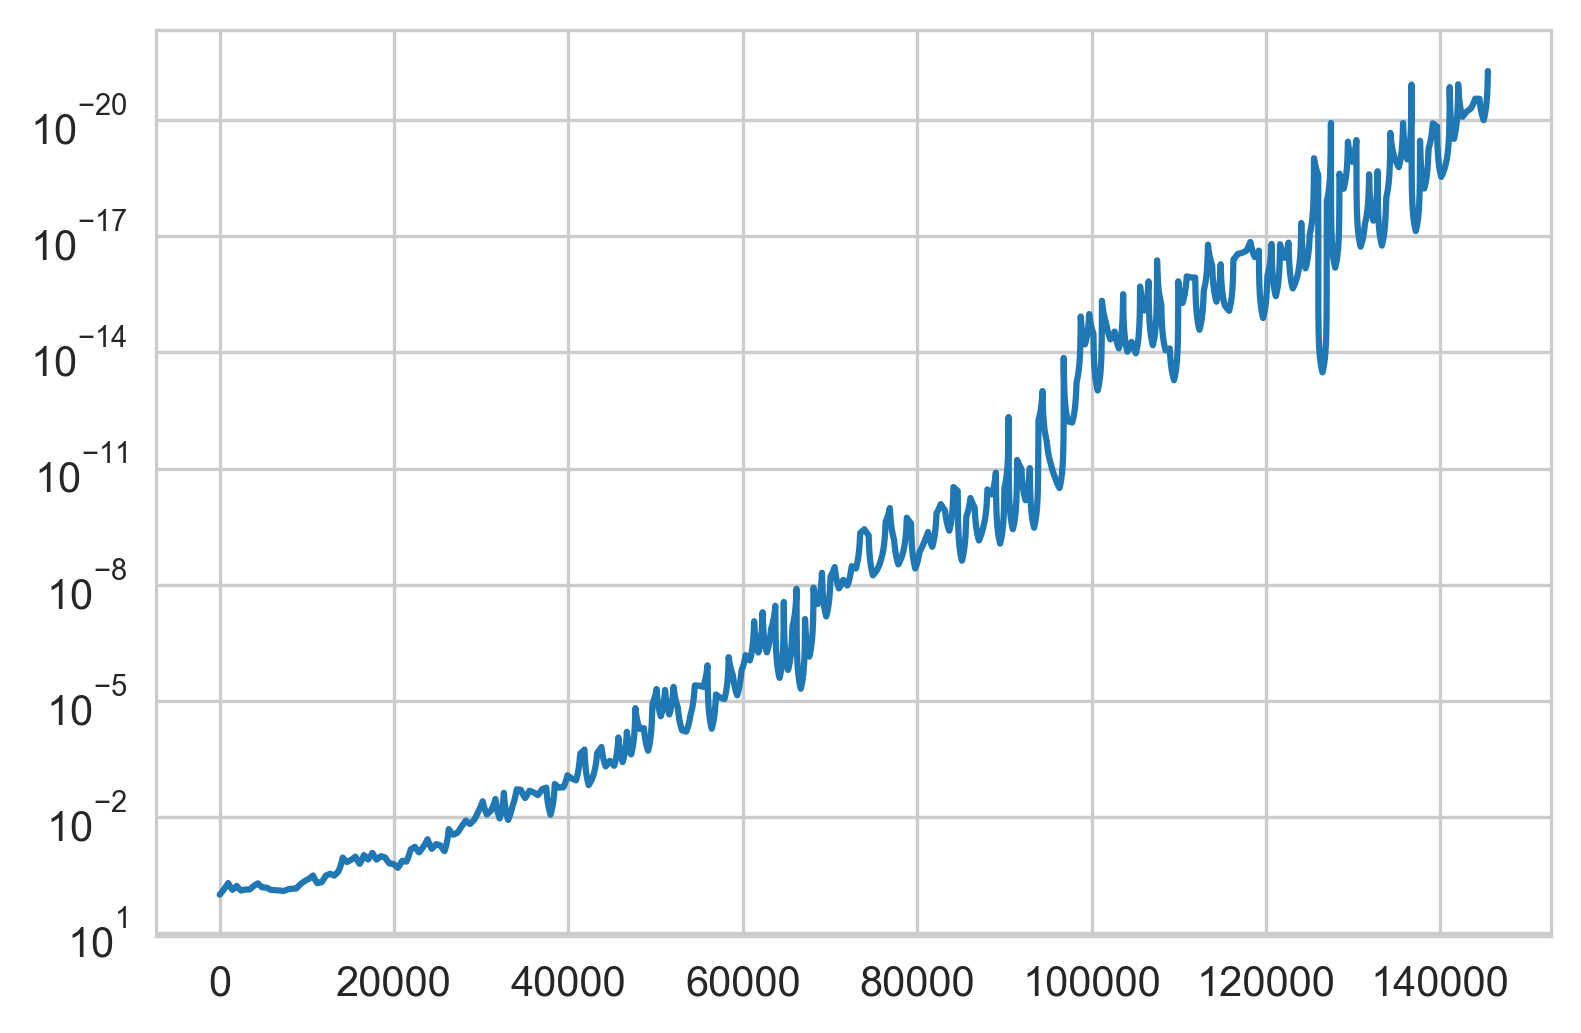

In [6]:
G = sns.lineplot(data=CRI_PG)
G.set(yscale='log') #, xlim=(94314,94320))
G.invert_yaxis()

In [7]:
def prepare_traces_dl(x, y, x_att, y_att):
    """
    Normalizes the traces, one-hot encodes the labels.
    Returns profiling traces, labels and attack traces, labels.
    """
    prof_mean, prof_std = x.mean(axis=0), x.std(axis=0)
    norm_x = (x - prof_mean) / prof_std
    norm_x_att = (x_att - prof_mean) / prof_std

    return norm_x, encode(y), norm_x_att, encode(y_att)

X, Y, X_ATT, Y_ATT = prepare_traces_dl(PROF_X, PROF_Y, *TRACE_SET.attack())

In [8]:
def make_mlp(x, y, x_attack, y_attack, params):
    mdl = Sequential()
    mdl.add(Dense(100, activation=params['activation'], input_shape=(x.shape[1],)))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(NUM_CLASSES, activation='softmax'))

    mdl.compile(optimizer=params['optimizer'], loss=params['losses'], metrics=['accuracy'])

    out = mdl.fit(x, y, shuffle=True, validation_data=(x_attack, y_attack), batch_size=params['batch_size'],
                  epochs=params['epochs'], verbose=False, callbacks=[TqdmCallback(verbose=0)])

    return out, mdl

def make_model_9(x, y, x_attack, y_attack):
    return make_mlp(x, y, x_attack, y_attack, {
        'activation':'relu',
        'optimizer': Adam(learning_rate=0.001),
        'losses': 'categorical_crossentropy',
        'batch_size': 150,
        'epochs': 5
    })[1]

0epoch [00:00, ?epoch/s]

/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


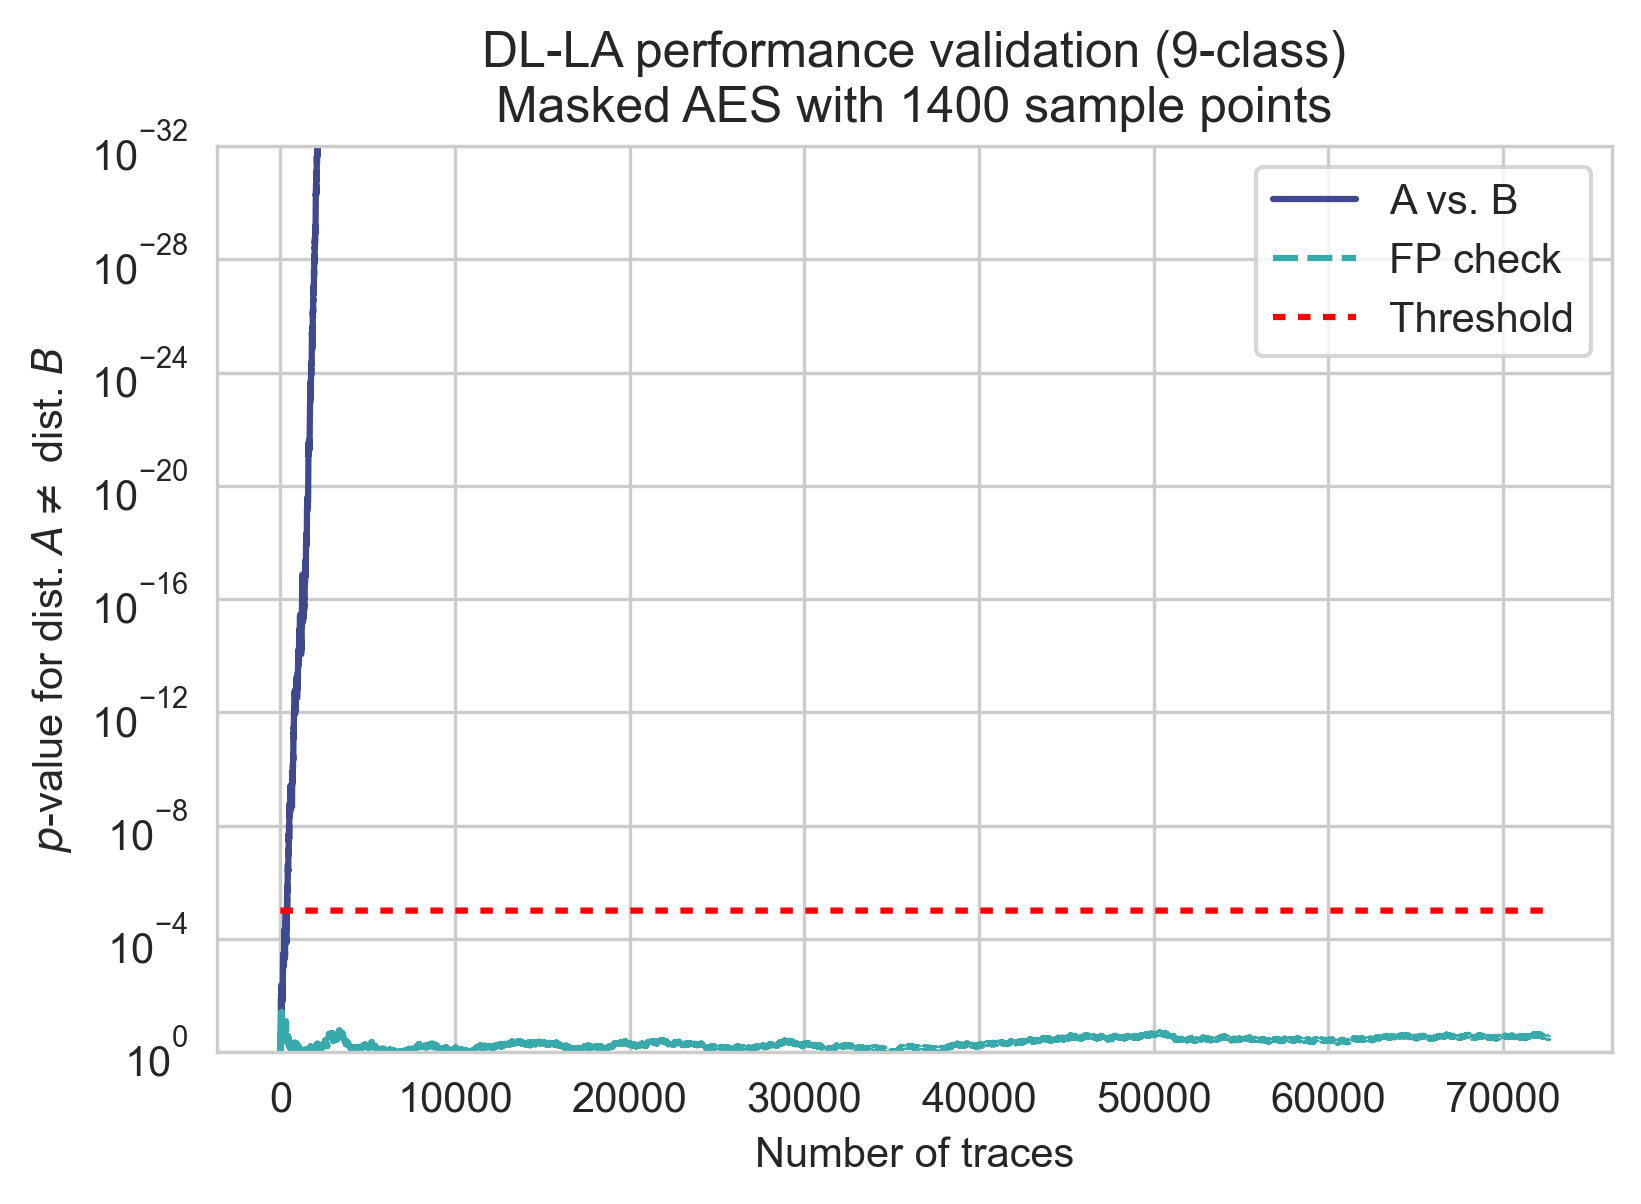

In [9]:
MODEL_9 = make_model_9(X, Y, X_ATT, Y_ATT)
PG_DLLA_9 = dlla_p_gradient(MODEL_9, X_ATT, Y_ATT)
PG_DLLA_9_RANDOM = dlla_p_gradient(MODEL_9, X_ATT, randomize(Y_ATT))

plot_p_gradient({
    "A vs. B": np.array(PG_DLLA_9),
    "FP check": np.array(PG_DLLA_9_RANDOM),
}, "DL-LA performance validation (9-class)\nMasked AES with 1400 sample points",
    palette=PALETTE_GRADIENT,
)

In [10]:
X_PROF_2, Y_PROF_2 = reduce_fixed_fixed(X, Y)
X_ATT_2, Y_ATT_2 = reduce_fixed_fixed(X_ATT, Y_ATT)
Y_ATT_2_RANDOM = randomize(Y_ATT_2)

Epoch 1/5
969/969 [==============================] - 2s 2ms/step - loss: 0.2495 - accuracy: 0.5330

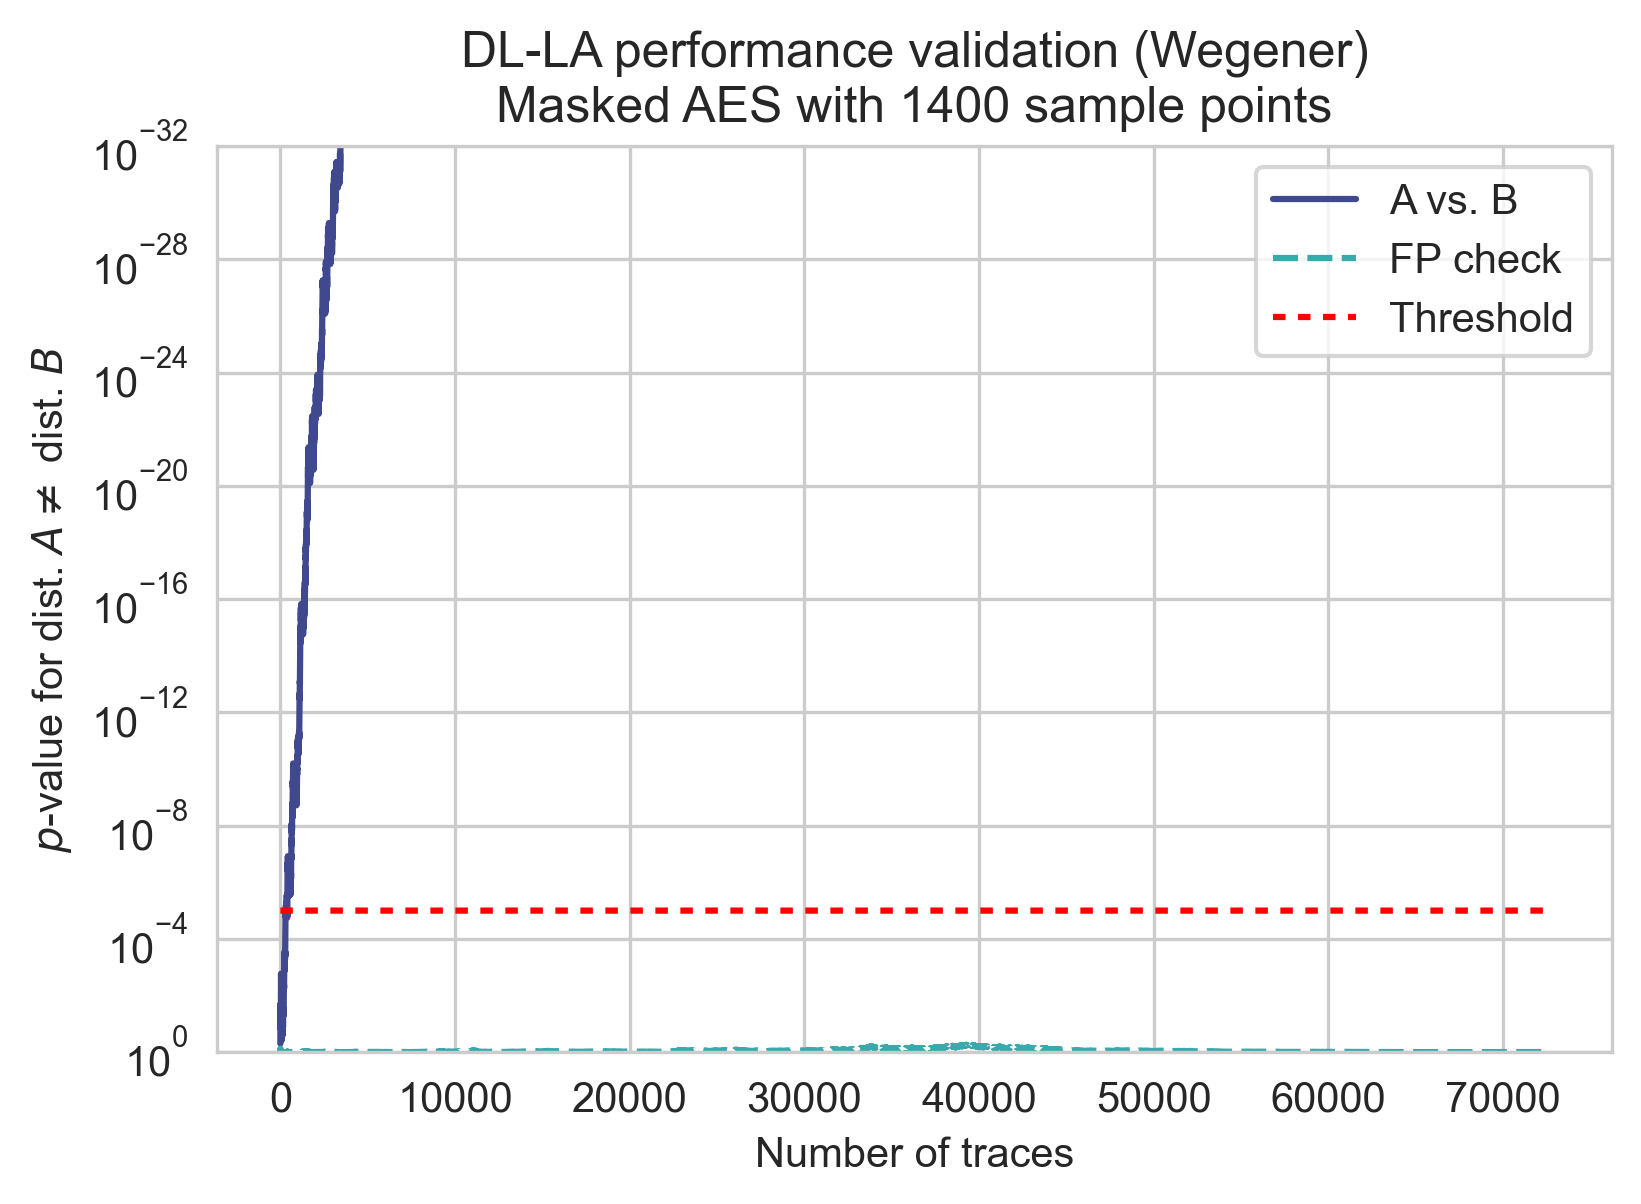

In [11]:
MODEL_WEGENER = make_mlp_wegener(X_PROF_2, Y_PROF_2)

PG_DLLA_2_AB = wegener_p_gradient(MODEL_WEGENER, X_ATT_2, Y_ATT_2)
PG_DLLA_2_RANDOM =  wegener_p_gradient(MODEL_WEGENER, X_ATT_2, Y_ATT_2_RANDOM)

plot_p_gradient({
    "A vs. B": np.array(PG_DLLA_2_AB),
    "FP check": np.array(PG_DLLA_2_RANDOM),
}, "DL-LA performance validation (Wegener)\nMasked AES with 1400 sample points",
    palette=PALETTE_GRADIENT,
)

In [ ]:
TRACE_LIMIT = min(len(PG_DLLA_9), len(PG_DLLA_2_AB), len(CRI_PG))

PGS = {
    "DL-LA 9-class": np.array(PG_DLLA_9),
    "DL-LA Wegener": np.array(PG_DLLA_2_AB),
    "TVLA $t$-test, $\mu_2$": CRI_PG
}

plot_p_gradient(PGS, "TVLA performance validation ($t$-test, $\\mu_2$)\nMasked AES with 1400 sample points", palette=PALETTE, file_name="ascad-masked-all")

In [13]:
PROF_Y_RANDOM = PROF_Y.copy()
np.random.shuffle(PROF_Y_RANDOM)

PGS_RANDOM = cri_p_gradient(PROF_X, PROF_Y_RANDOM, tvla_cri(*prepare_tvla(PROF_X, PROF_Y_RANDOM), max_order=2, progress=False))

CRI p-gradient:   0%|          | 0/20 [00:00<?, ?it/s]/home/berg/Documents/Afstudeer/LA/src/tvla/tvla.py:61: RuntimeWarning: Mean of empty slice.
  self.mean = traces.mean(axis=0)
/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/berg/Documents/Afstudeer/LA/src/tvla/tvla.py:80: RuntimeWarning: invalid value encountered in true_divide
  cm = np.sum(mean_free ** order, axis=0) / self.num_traces
CRI p-gradient: 100%|██████████| 20/20 [00:43<00:00,  2.17s/it]


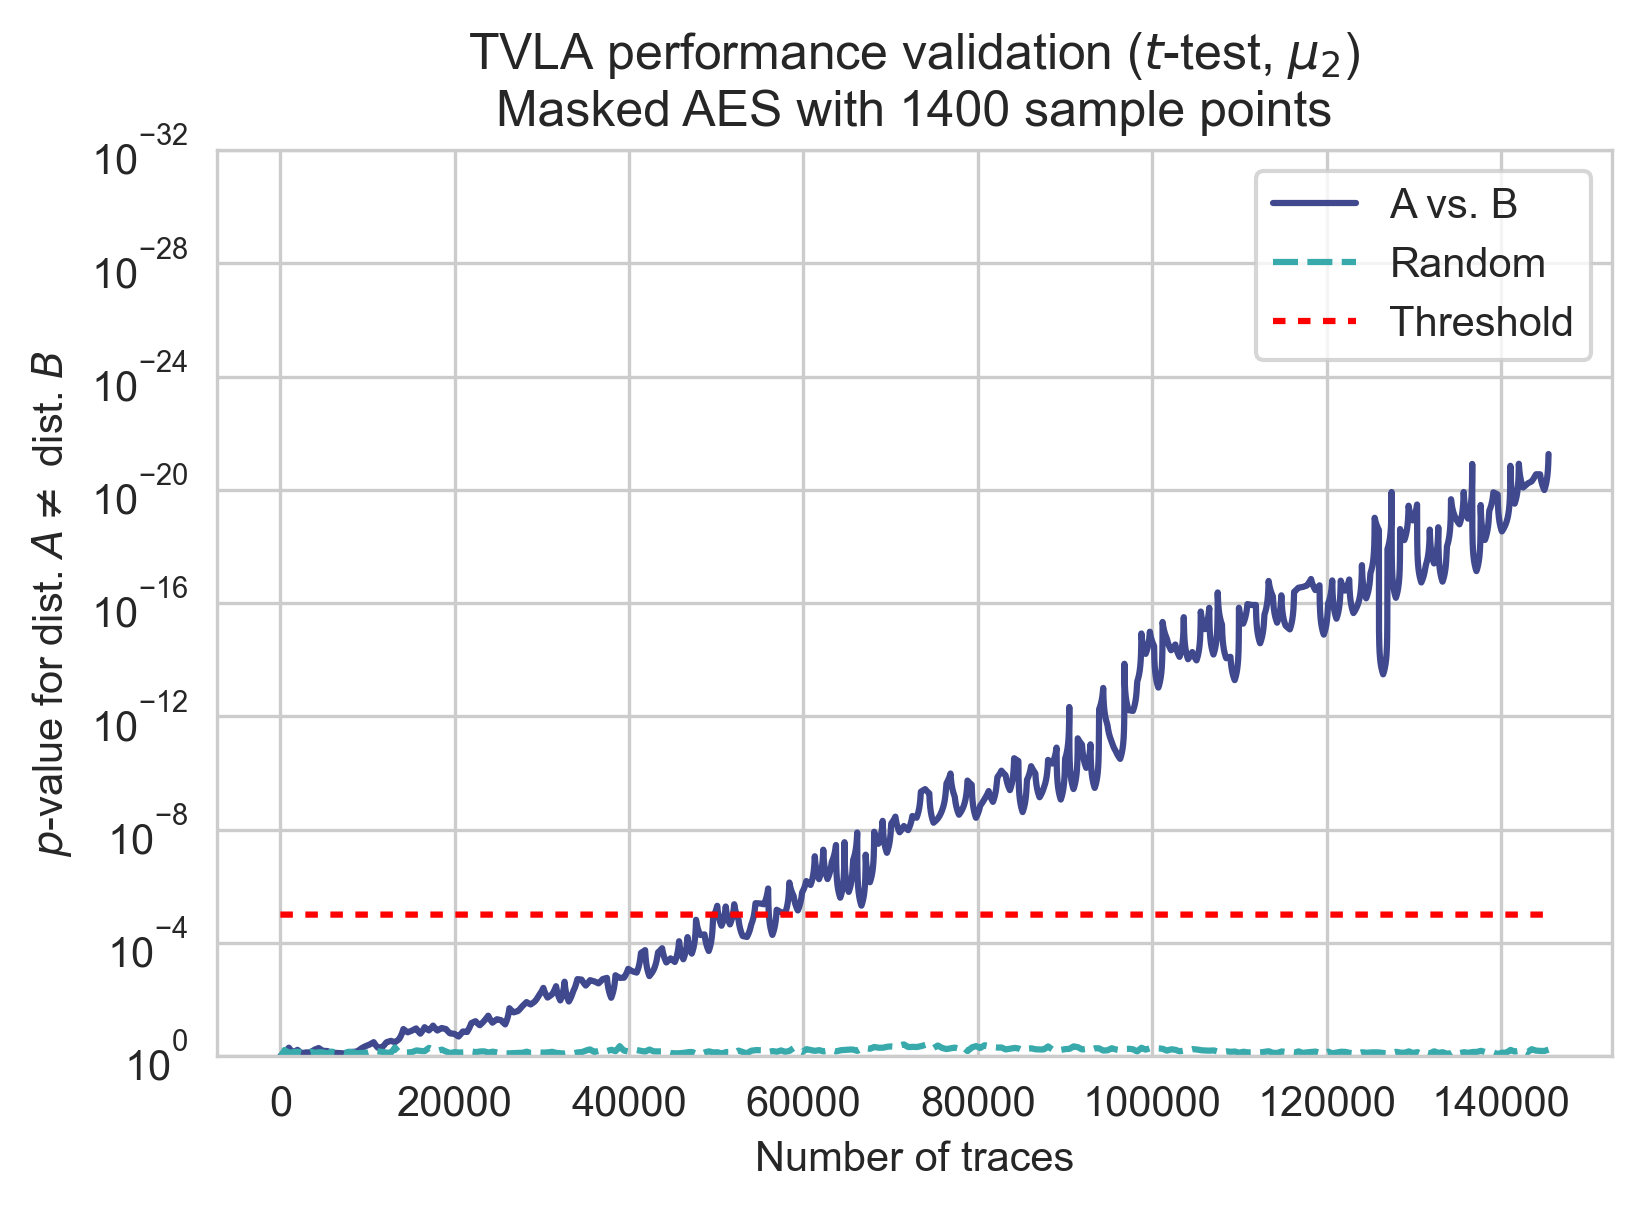

In [14]:
plot_p_gradient({
    "A vs. B": CRI_PG,
    "Random": PGS_RANDOM,
}, "TVLA performance validation ($t$-test, $\\mu_2$)\nMasked AES with 1400 sample points",
    palette=PALETTE_GRADIENT,
    file_name="tvla-cri-validation-mu2")

# DF = pd.DataFrame(PGS)
# DF.to_csv(f"dlla-p-gradient{FILE_SUFFIX}.csv")

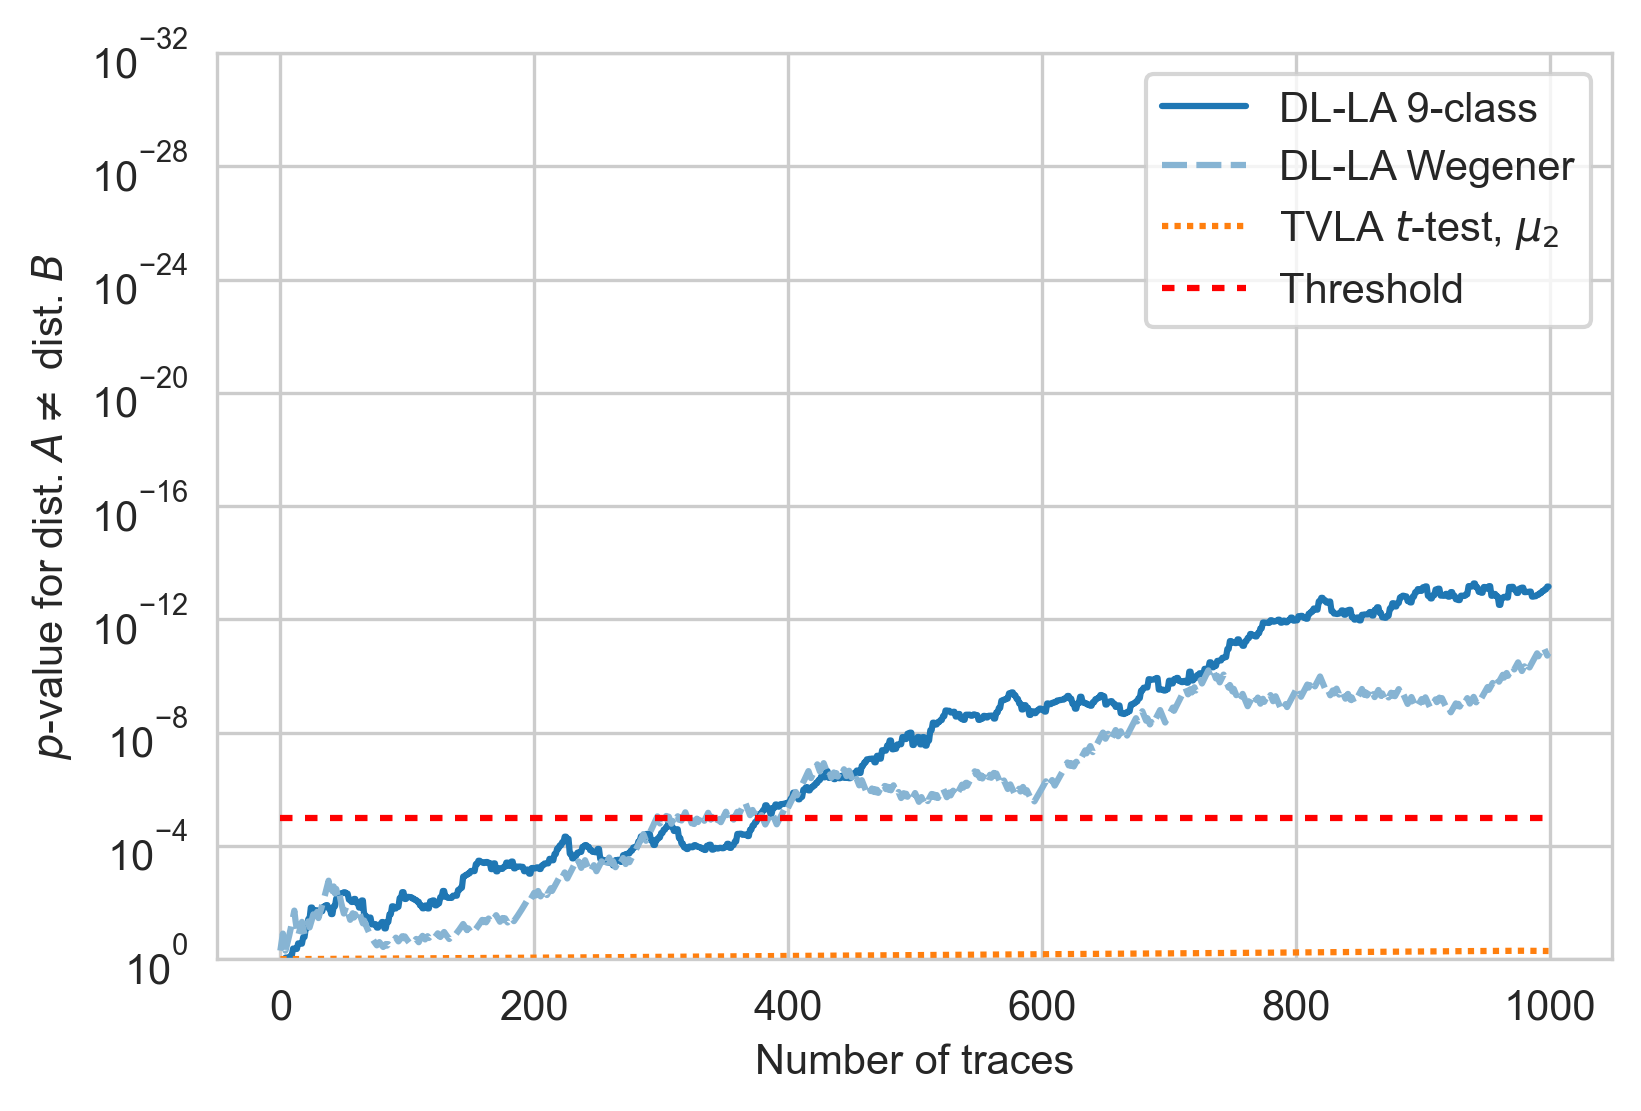

In [16]:
LIMIT = 1000
PGS_LIMIT = {
    "DL-LA 9-class": np.array(PG_DLLA_9[:LIMIT]),
    "DL-LA Wegener": np.array(PG_DLLA_2_AB[:LIMIT]),
    "TVLA $t$-test, $\mu_2$": CRI_PG[:LIMIT]
}

plot_p_gradient(PGS_LIMIT, palette=PALETTE)

DF = pd.DataFrame(PGS_LIMIT)
DF.to_csv(f"dlla-p-gradient{FILE_SUFFIX}-1000.csv")

Taking TVLA-favoured window between (187, 188).


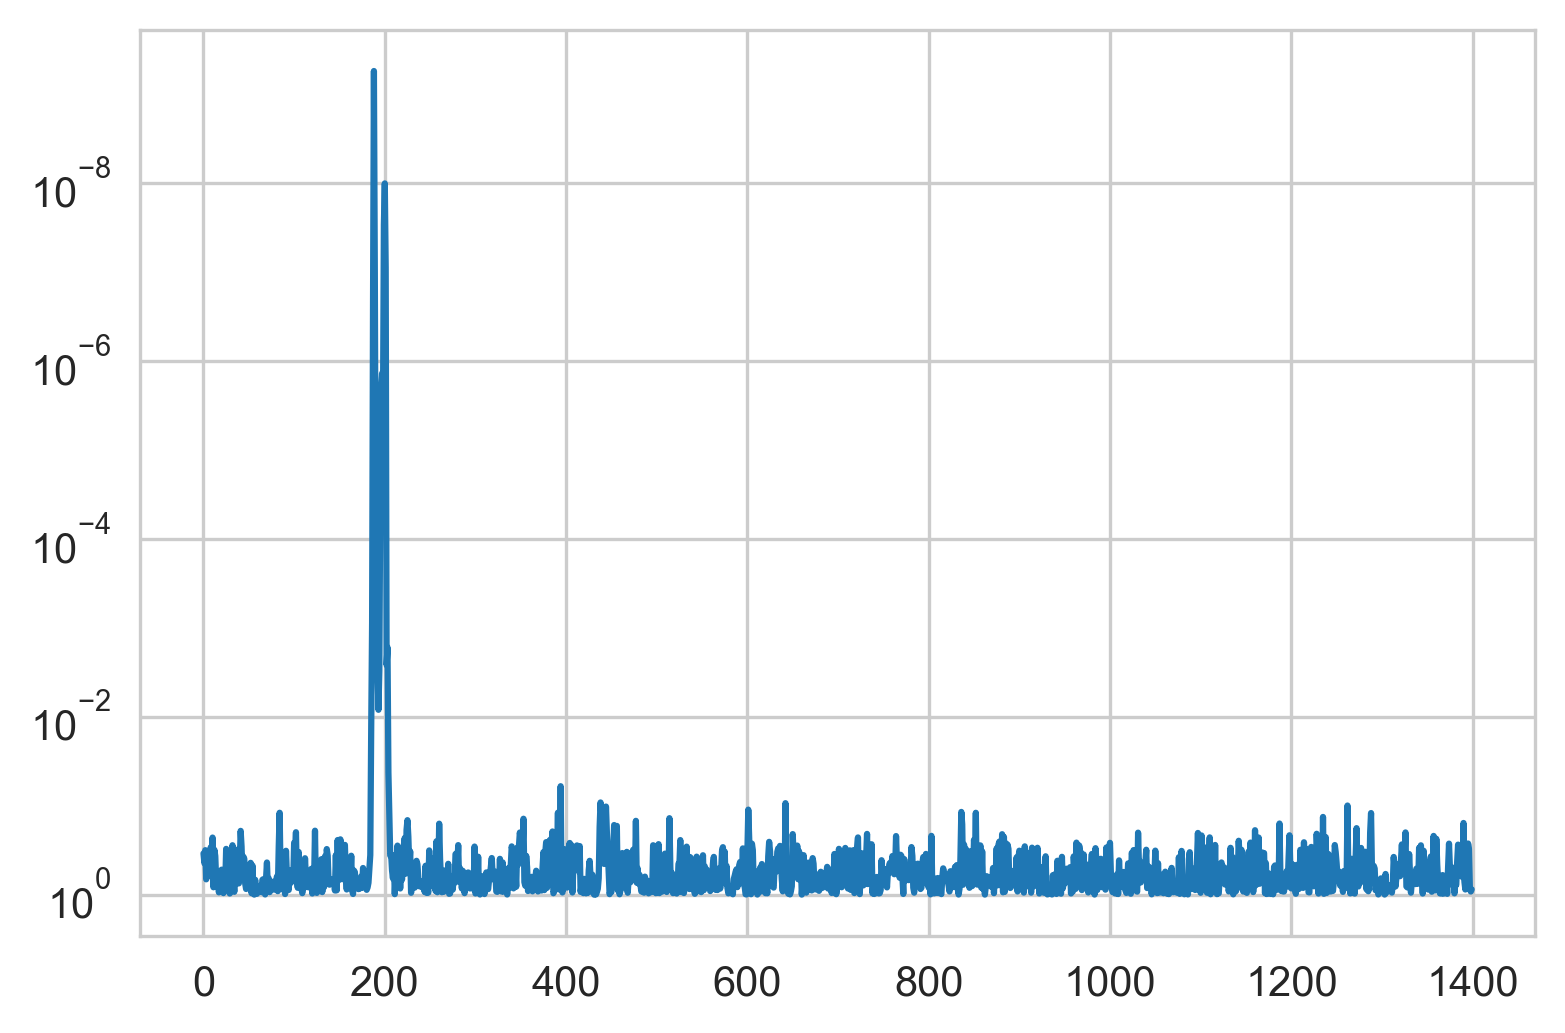

In [18]:
CRI_P2 = PVS_CRI[2]
G = sns.lineplot(data=CRI_P2)
G.set(yscale="log")
G.invert_yaxis()

T_BREAK = CRI_P2 < 10 ** -5
A = np.argmax(T_BREAK)
B = A + 1 # len(CRI_P2) - np.argmax(list(reversed(T_BREAK)))

print(f"Taking TVLA-favoured window between ({A}, {B}).")

In [19]:
TVLA_X = X[:, A:B]
TVLA_X_ATT = X_ATT[:, A:B]

In [20]:
TVLA_MODEL_9 = make_model_9(TVLA_X, Y, TVLA_X_ATT, Y_ATT)
TVLA_PG_DLLA_9 = dlla_p_gradient(TVLA_MODEL_9, TVLA_X_ATT, Y_ATT)

0epoch [00:00, ?epoch/s]

/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [21]:
TVLA_X2, TVLA_Y2 = reduce_fixed_fixed(TVLA_X, Y)
TVLA_X2_ATT, TVLA_Y2_ATT = reduce_fixed_fixed(TVLA_X_ATT, Y_ATT)

In [22]:
TVLA_PG_DLLA_2 = wegener_p_gradient(make_mlp_wegener(TVLA_X2, TVLA_Y2), TVLA_X2_ATT, TVLA_Y2_ATT)

Epoch 1/5
969/969 [==============================] - 1s 1ms/step - loss: 0.2499 - accuracy: 0.5088

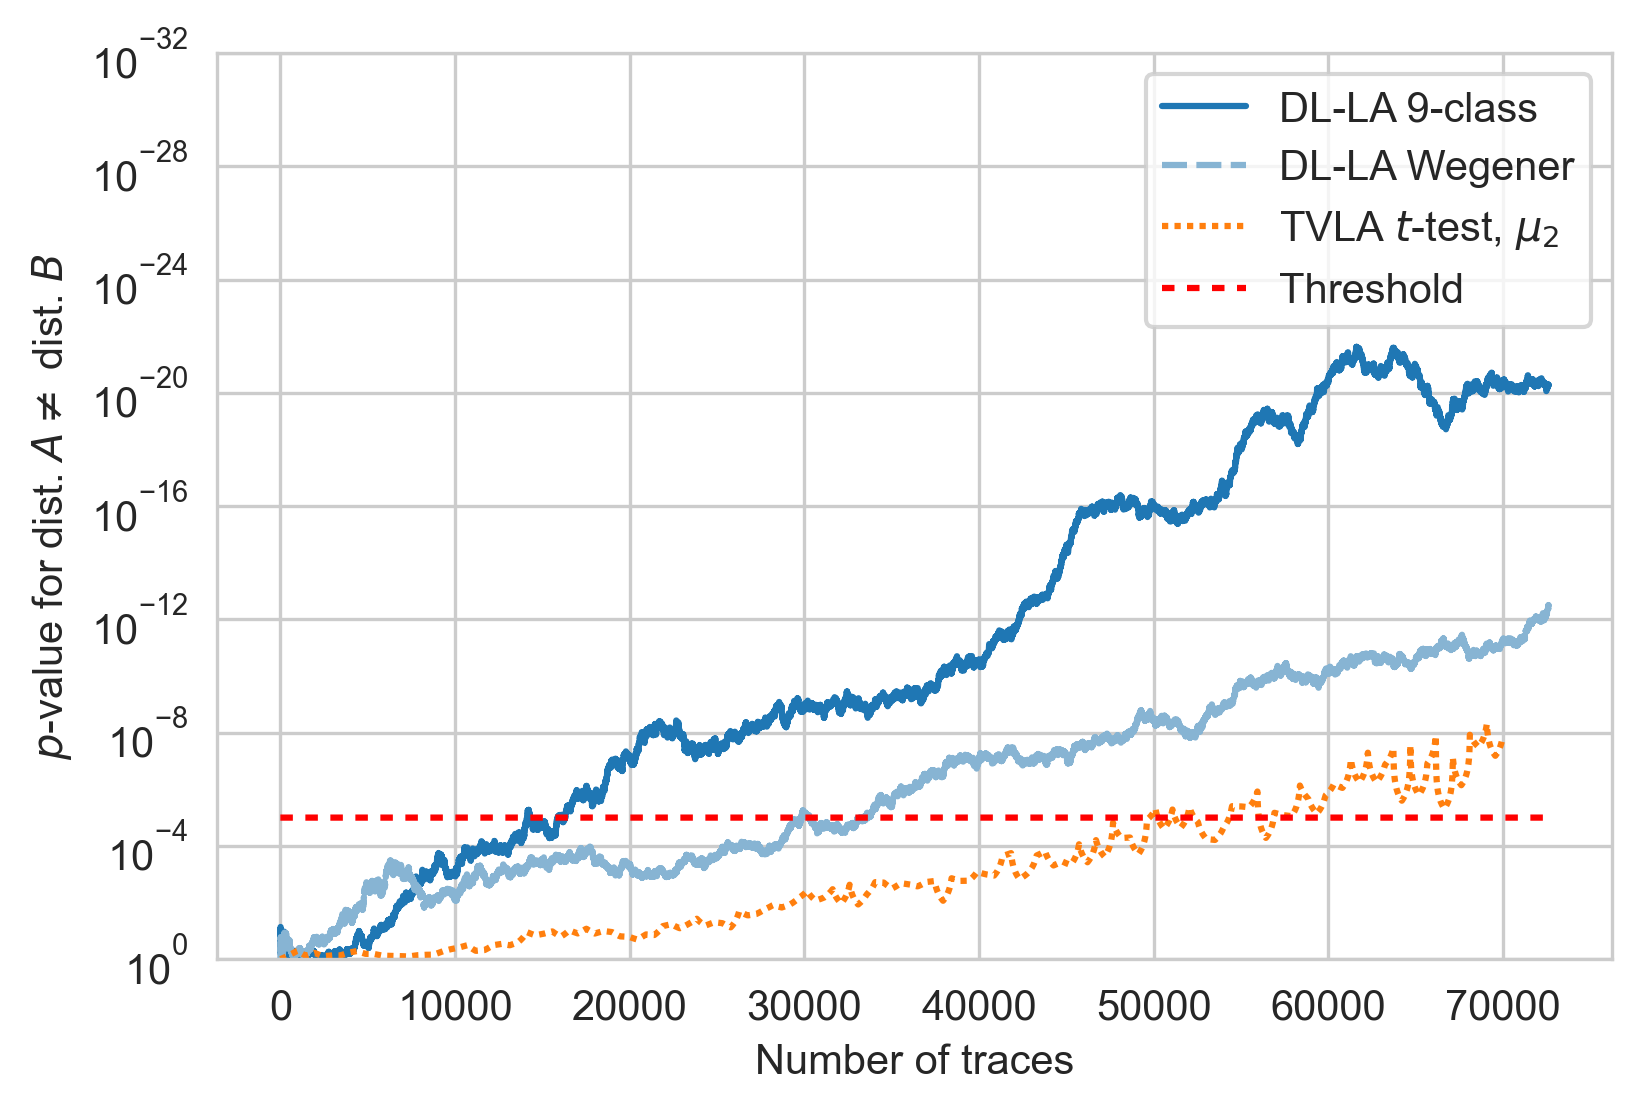

In [23]:
PGS = {
    "DL-LA 9-class": np.array(TVLA_PG_DLLA_9),
    "DL-LA Wegener": np.array(TVLA_PG_DLLA_2),
    "TVLA $t$-test, $\mu_2$": CRI_PG[:70000]
}

plot_p_gradient(PGS, palette=PALETTE, file_name="ascad-inside-poi")

In [24]:
DLLA_START = len(CRI_P2) - np.argmax(list(reversed(T_BREAK))) + 20

print(f"Taking DLLA-favoured window between ({DLLA_START}, {len(CRI_P2)}).")

Taking DLLA-favoured window between (222, 1400).


In [25]:
DLLA_X = X[:, DLLA_START:]
DLLA_X_ATT = X_ATT[:, DLLA_START:]

In [26]:
DLLA_CRI_PG = cri_p_gradient(DLLA_X, PROF_Y, tvla_cri(*prepare_tvla(DLLA_X, PROF_Y), max_order=2, progress=False))

CRI p-gradient:   0%|          | 0/20 [00:00<?, ?it/s]/home/berg/Documents/Afstudeer/LA/src/tvla/tvla.py:61: RuntimeWarning: Mean of empty slice.
  self.mean = traces.mean(axis=0)
/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/berg/Documents/Afstudeer/LA/src/tvla/tvla.py:80: RuntimeWarning: invalid value encountered in true_divide
  cm = np.sum(mean_free ** order, axis=0) / self.num_traces
CRI p-gradient: 100%|██████████| 20/20 [00:33<00:00,  1.68s/it]


In [27]:
DLLA_MODEL_9 = make_model_9(DLLA_X, Y, DLLA_X_ATT, Y_ATT)
DLLA_PG_DLLA_9 = dlla_p_gradient(DLLA_MODEL_9, DLLA_X_ATT, Y_ATT)

0epoch [00:00, ?epoch/s]

/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [28]:
DLLA_X2, DLLA_Y2 = reduce_fixed_fixed(DLLA_X, Y)
DLLA_X2_ATT, DLLA_Y2_ATT = reduce_fixed_fixed(DLLA_X_ATT, Y_ATT)

In [29]:
DLLA_PG_DLLA_2 = wegener_p_gradient(make_mlp_wegener(DLLA_X2, DLLA_Y2), DLLA_X2_ATT, DLLA_Y2_ATT)

Epoch 1/5
969/969 [==============================] - 3s 2ms/step - loss: 0.2531 - accuracy: 0.5004

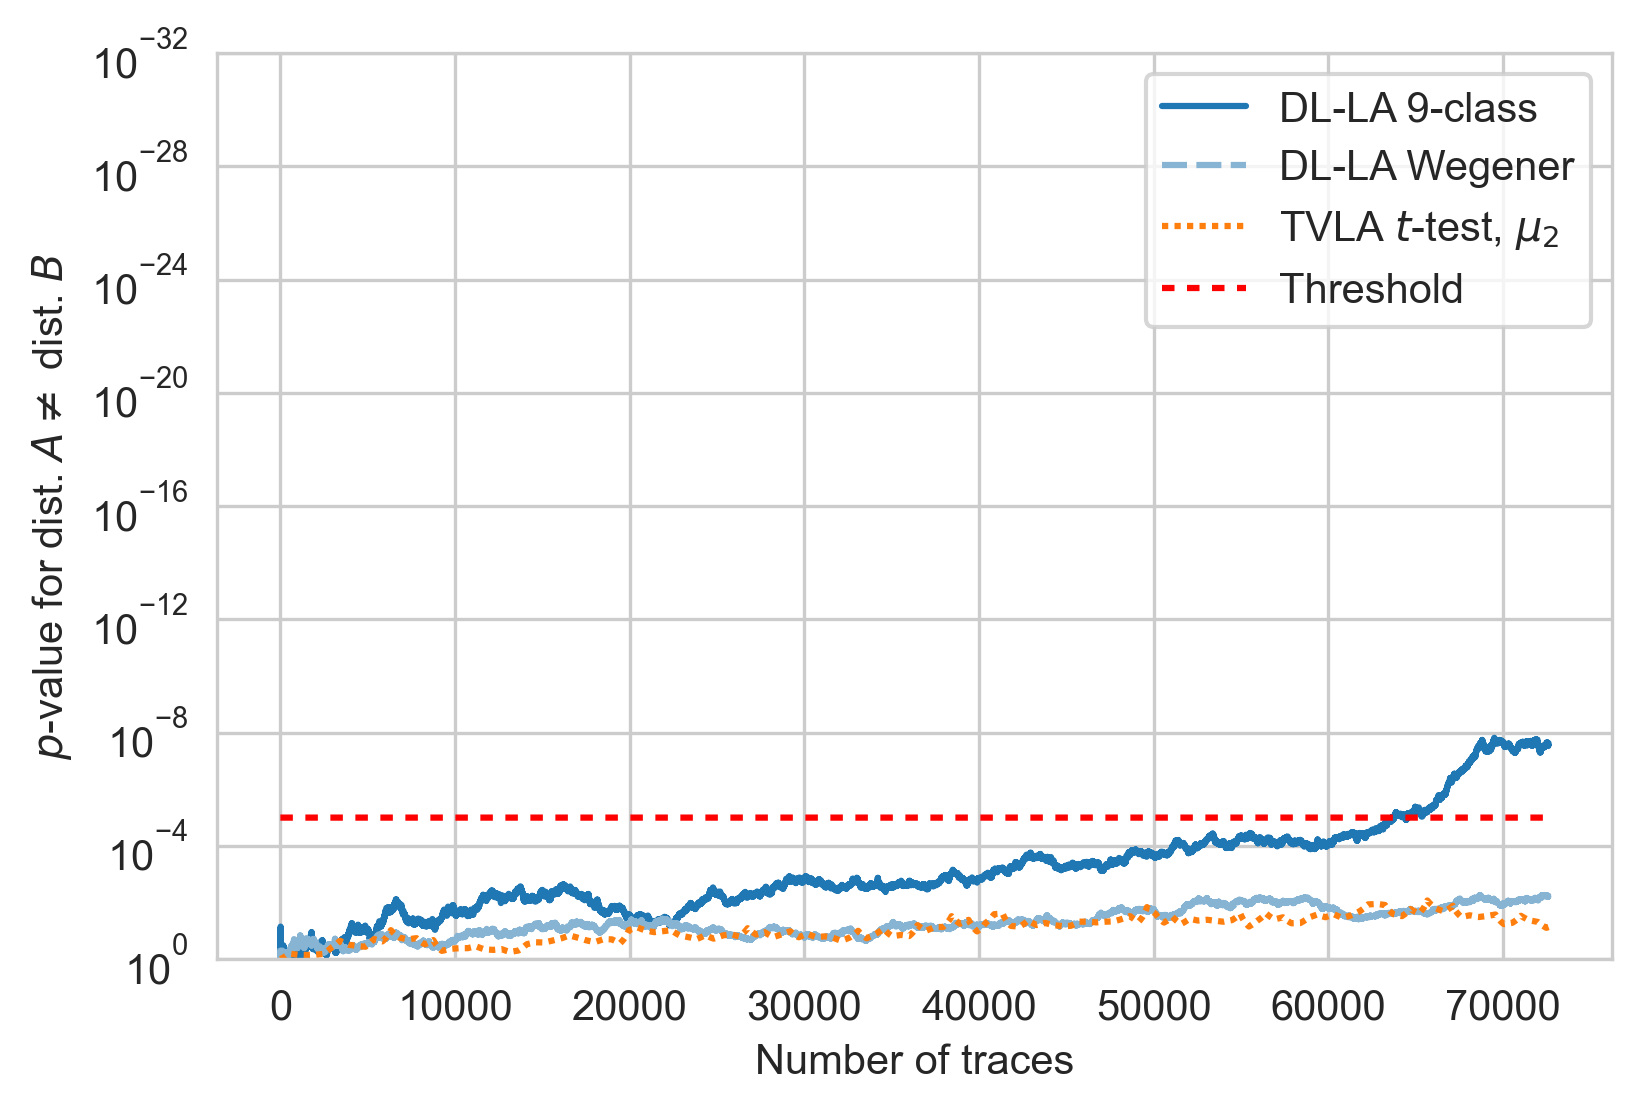

In [30]:
PGS = {
    "DL-LA 9-class": np.array(DLLA_PG_DLLA_9[:TRACE_LIMIT]),
    "DL-LA Wegener": np.array(DLLA_PG_DLLA_2[:TRACE_LIMIT]),
    "TVLA $t$-test, $\mu_2$": DLLA_CRI_PG[:TRACE_LIMIT]
}

plot_p_gradient(PGS, palette=PALETTE, file_name="ascad-outside-poi")
